In [40]:
import pandas as pd
import matplotlib as mpl
from scipy import stats
import scipy.special
import os
from scipy import constants
from colossus.cosmology import cosmology
from astropy.cosmology import z_at_value
from astropy import units as unit
from astropy.coordinates import SkyCoord
params = {'flat': True, 'H0': 67.77, 'Om0': 0.307, 'Ob0': 0.04825, 'sigma8': 0.8288, 'ns': 0.9611}
cosmology.addCosmology('planck14', params)
cosmo = cosmology.setCosmology('planck14')

In [41]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator, FixedLocator
from matplotlib.backends.backend_pdf import PdfPages

plt.style.use("shao.mplstyle")
fontSize = 15
lineWidth = 1.5

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', \
          u'#bcbd22', u'#17becf']

# 1 read data

In [42]:
def read_data(file, mass_min = 100, r_min = 300):
# within 300kpc, > mass_min, after tidal destruction

    with h5py.File(file, 'r' ) as hf:
        # data = hf[inputFile]
        # print ("data.keys = " , data.keys())
        # gid = data['GalaxyID'][:]
        # num = len(gid)
        print("hf.keys()", hf.keys())
        # print("hf/satellite_galaxies.keys()",hf['satellite_galaxies'].keys())
        t = hf["header_info/time"][:]
        a = hf["header_info/scale_factor"][:]
        h = hf['header_info/h'][()].astype(np.float64)
        # central_Mhalo = hf['central_galaxy/Mhalo'][:]
        satellite_mstar = hf['satellite_galaxies/Mstar'][:]
        # satellite_msub = hf['satellite_galaxies/Msub'][:]
        satellite_mhalo = hf['satellite_galaxies/Mhalo'][:]
        satellite_pos = hf['satellite_galaxies/pos'][:]
        # central_pos = hf['satellite_galaxies/pos'][:]
        satellite_vel = hf['satellite_galaxies/vel'][:]
        satellite_R200 = hf['satellite_galaxies/R200'][:]
        # is_MW_central = hf['satellite_galaxies/is_MW_central'][:]
        # Last snapshot at which the galaxy is a FOF central subhalo. Different from Galform definition of central galaxy.
        # satellite_snap_last_FOF_central = hf['satellite_galaxies/snap_last_FOF_central'][:]
        # Last snapshot at which the galaxy was a central.
        # satellite_snap_last_central = hf["satellite_galaxies/snap_last_central"][:]
        # satellite_type = hf["satellite_galaxies/type"][:]
        destruction = hf["tidal_disruption/destroyed_orbit_interpolation"][:]
    print("d<300,m>0 satellite num=", len(satellite_mstar))
    print("d<300,m>100 satellite num=", sum(satellite_mstar[:,0]>100))
    
    # R200 = 227.2 * (central_Mhalo/1.252e12)**0.3333
    is_satellite = np.logical_and(satellite_mstar[:,0]>mass_min, destruction==False)
    satellite_mstar = satellite_mstar[is_satellite]
    satellite_pos = satellite_pos[is_satellite]
    satellite_mhalo = satellite_mhalo[is_satellite]
    satellite_vel = satellite_vel[is_satellite]
    satellite_R200 = satellite_R200[is_satellite]
    print("d<300,m>100 after destruction satellite num=", sum(is_satellite))
    return satellite_mstar, satellite_pos, satellite_vel, satellite_mhalo, satellite_R200, t, a, h

In [43]:
def read_hydro(simulation_num, simulation_name, maxn):
    # read the subgroup catalogue
    # inputFile_root = "groups_199_z000p000/eagle_subfind_tab_028_z000p000.%i.hdf5" 
    file = simulation_name
    inputFile_root = '/home/zhaox/Magpie/' + file + '/groups_199_z000p000/eagle_subfind_tab_199_z000p000.%i.hdf5'
    # read the data - read the first tab file to get the total number of subgroups
    inputFile = inputFile_root % 0

    # 对于4和5，中央星系的galaxyID不等于0

    if simulation_name[3:] == 'zcut7':
        if simulation_num == 4:
            centerIndex = 2
        elif simulation_num == 5:
            centerIndex = 2
        else:
            centerIndex = 1
    elif simulation_name[3:] == '7DM_GAS':
        if simulation_num == 2:
            centerIndex = 2
        elif simulation_num == 4:
            centerIndex = 3
        else:
            centerIndex = 1
    else:
        print("can't understand simulation_name!")
        return
    with h5py.File( inputFile, 'r' ) as hf:
        header  = hf['Header'].attrs
        # print ('header keys:', header.keys())
        numFiles = header['NTask']  # this gives the number of files in which the group catalog is saved
        noTotGrps = header['TotNgroups']  # total number of FOF groups
        noTotSubs = header['TotNsubgroups']  # total number of SUBFIND subhaloes
        hFactor   = header['HubbleParam']
        # print("All groups in the file:", hf.keys())
        # print("All entries in the 'FOF' group:", hf['FOF'].keys())
        # print("All entries in the 'SubHalo' group:", hf['Subhalo'].keys())
        # print(numFiles, noTotGrps, noTotSubs, hFactor)


    # reserve memory for the output arrays
    FOF_length   = np.zeros( noTotGrps, np.uint32 )
    FOF_mass     = np.zeros( noTotGrps, np.float32 )
    FOF_pos      = np.zeros( (noTotGrps,3), np.float32 )  # centre of potential
    FOF_M200     = np.zeros( noTotGrps, np.float32 )
    FOF_R200     = np.zeros( noTotGrps, np.float32 )
    Subhalo_mass = np.zeros( noTotSubs, np.float32 )
    Subhalo_pos  = np.zeros( (noTotSubs,3), np.float32 )  # centre of potential
    Subhalo_vel = np.zeros( (noTotSubs,3), np.float32 )
    Subhalo_gnum = np.zeros( noTotSubs, np.float32 )

    # loop over all the various files
    start, end = 0, 0
    start2, end2 = 0, 0
    for i in range(numFiles):
        inFile = inputFile_root % i
        with h5py.File( inFile, 'r' ) as hf:
            h = hf['Header'].attrs
            numGrps = h['Ngroups']  # number of groups this file
            numsubGrps = h['Nsubgroups']
            end = start + numGrps
            end2 = start2 + numsubGrps
    #         print(numsubGrps)
            # print ("Reading file %i of %i --%s-- which contains %i groups ..." % ( i+1, numFiles, inFile, numGrps ))
            
            # FOF_length[start:end] = hf["FOF/GroupLength"]
            # FOF_mass[start:end] = hf["FOF/GroupMass"]
            FOF_pos[start:end]  = hf["FOF/GroupCentreOfPotential"]
            # FOF_M200[start:end] = hf["FOF/Group_M_Crit200"]
            FOF_R200[start:end] = hf["FOF/Group_R_Crit200"]
            Subhalo_pos[start2:end2] = hf["Subhalo/CentreOfPotential"]
            Subhalo_mass[start2:end2] = hf["Subhalo/MassType"][:,4]
            Subhalo_vel[start2:end2] = hf["Subhalo/Velocity"]
            Subhalo_gnum[start2:end2] = hf["Subhalo/GroupNumber"]
            start = end
            start2 = end2
    Subhalo_pos = (Subhalo_pos - FOF_pos[centerIndex-1])* 1000/hFactor
    satellite_index = []
    dis = []
    for i in range(len(Subhalo_pos)):
        dis_ = ((Subhalo_pos[i][0]**2 + Subhalo_pos[i][1]**2 + Subhalo_pos[i][2]**2)**0.5)
        # 筛选条件小于300kpc，大于100msun
        # print(dis_)
        if  dis_  < 300 and Subhalo_mass[i] > 0:
            satellite_index.append(i)
            dis.append(dis_)
    # print(satellite_index)
    # 选择groupNumber==centerindex的星系
    # satellite_index = np.where(Subhalo_gnum == centerIndex)

    # print(satellite_index)
    print('r200 = ',FOF_R200[centerIndex-1])
    #计算相对坐标和相对速度
    # satellite_pos = (Subhalo_pos[satellite_index] - FOF_pos[centerIndex-1])* 1000/hFactor
    satellite_pos = Subhalo_pos[satellite_index]
    satellite_vel = Subhalo_vel[satellite_index] - Subhalo_vel[satellite_index][0]
    dis = np.linalg.norm(satellite_pos, axis = 1)
    satellite_data =pd.DataFrame({"groupNumber":Subhalo_gnum[satellite_index], "id":satellite_index,\
            "mass":Subhalo_mass[satellite_index]*1e10/hFactor, "distance[kpc]":dis, \
            "x[kpc]":satellite_pos[:,0],"y[kpc]":satellite_pos[:,1],"z[kpc]":satellite_pos[:,2],\
            "vx[km/s]":satellite_vel[:,0],"vy[km/s]":satellite_vel[:,1],"vz[km/s]":satellite_vel[:,2]},  \
        columns=['groupNumber', 'id', 'mass', 'distance[kpc]', 'x[kpc]', 'y[kpc]', 'z[kpc]', 'vx[km/s]', 'vy[km/s]', 'vz[km/s]'])
        # 返回显示质量最大的maxn个,maxn=1000表示输出所有满足条件的星系，从1开始是因为0是中央星系
    # satellite_data = all_data[all_data['groupNumber'] == centerIndex+1] 
    # satellite_data = satellite_data.query("mass > 0 & `distance[kpc]` < 300")
    # satellite_index = np.where(satellite_data['groupNumber'] == centerIndex)
    # satellite_data = satellite_data.iloc[satellite_index]
    satellite_data = satellite_data.sort_values(by=['mass'],ascending=False)
    # satellite_data = satellite_data.loc[satellite_data['distance[kpc]']<300 ]
    satellite_pos = np.array(satellite_data[['x[kpc]','y[kpc]','z[kpc]']])
    satellite_vel = np.array(satellite_data[['vx[km/s]','vy[km/s]','vz[km/s]']])
    
    print('center pos:', FOF_pos[centerIndex-1], "satellite num = ", len(satellite_pos)-1)
    return FOF_R200[centerIndex-1], satellite_data.iloc[:maxn+1], satellite_pos[1:maxn+1], satellite_vel[1:maxn+1]
    # return satellite_data.sort_values(by=['mass'],ascending=False).iloc[:]


In [44]:
def read_central_r200(simulation_name):
    simulation_num = int(simulation_name[1])
    if simulation_name[3:] == 'zcut7':
        if simulation_num == 4:
            centerIndex = 2
        elif simulation_num == 5:
            centerIndex = 2
        else:
            centerIndex = 1
    elif simulation_name[3:] == '7DM_GAS':
        if simulation_num == 2:
            centerIndex = 2
        elif simulation_num == 4:
            centerIndex = 3
        else:
            centerIndex = 1
    h = 0.6777
    mw_stellar, mw_snap, mw_groupnum, mw_subgroupnum, mw_subpos, mw_redshift, mw_halo = \
                find_main_branch_stellar_new(199, centerIndex, 0)
    snap = mw_snap
    groupnum = mw_groupnum
    r200 = []
    # m200 = []

    filedir = '/Simulations/Magpie/' + simulation_name 
    filename = os.listdir(filedir)
    filename_group = [name for name in filename if name[:6]=='groups' and name[-3:]!='tar']
    Num = np.array([int(filename[7:10]) for filename in filename_group])
    for i in snap[::-1]:
        print(i)
        j = np.where(Num==i)[0][0]
        filedir_group = filedir + '/' + filename_group[j]
        filenamelist_all_group = os.listdir(filedir_group)
        filenamelist_group = [filenamelist_all_group[i] for i in range(len(filenamelist_all_group))\
                            if filenamelist_all_group[i].split('.')[0][:17] == 'eagle_subfind_tab' ]
        R200 = []
        # M200 = []
        for k in range(len(filenamelist_group)):
            filedata_group = h5py.File(filedir_group + '/' + filenamelist_group[k][:30] + '.%0.f.hdf5' % k, 'r')
            catalog = list(filedata_group['FOF'].keys())
            if 'Group_R_Crit200' in catalog:
                R200 += list(filedata_group['FOF/Group_R_Crit200'])
                # M200 += list(filedata_group['FOF/Group_M_Crit200'])
        R200 = np.vstack(R200)
        # M200 = np.vstack(M200)
        if len(R200) < groupnum[snap==i]-1:
            r200.append(np.array([[0]]))
        else:
            r200.append(R200[groupnum[snap==i]-1])
        # m200.append(M200[groupnum[snap==i]-1])
    mw_r200 = np.array([r200[i][0][0] for i in range(len(r200))])[::-1]    # cMpc/h
    mw_r200_phy = mw_r200 * 1/(1+mw_redshift) * 1000 / h   
    return mw_r200_phy[1:][::-1]

In [45]:
# central_R200_l = np.loadtxt('central_R200.txt')
simulation_num = 1
simulation_name = 'M' + str(simulation_num) + '_zcut7'
file = "/home/zhaox/Magpie/Destruction/satellite_orbits_Galform/M" + str(simulation_num) + "_MR.hdf5"
# central_R200 = central_R200_l[simulation_num - 1]
# simulation_name = 'M' + str(simulation_num) + '_7DM_GAS'
# file = "/home/zhaox/Magpie/Destruction/satellite_orbits_Galform/M" + str(simulation_num) + "_7DM_GAS.hdf5"
# central_R200 = central_R200_l[simulation_num + 4]

In [46]:
# central_R200 = read_central_r200(simulation_name)

In [47]:
# np.savetxt('./data/mw_r200_M4_zcut7', central_R200_fill)

In [48]:
satellite_mstar, satellite_pos, satellite_vel, satellite_mhalo, satellite_R200, t, a, h = read_data(file)
L = np.cross(satellite_pos, satellite_vel)
satellite_num = len(satellite_pos)
print("satellite_pos.shape:", satellite_pos.shape)

hf.keys() <KeysViewHDF5 ['central_galaxy', 'header_info', 'metadata', 'satellite_galaxies', 'tidal_disruption']>
d<300,m>0 satellite num= 141
d<300,m>100 satellite num= 130
d<300,m>100 after destruction satellite num= 95
satellite_pos.shape: (95, 199, 3)


# 2 analyse z=0 after destruction

In [49]:
def cal_c_a_ratio(satellite_coordinate):
    n = len(satellite_coordinate)
    I = np.zeros([3,3])
    for i in range(3):
        for j in range(3):
            for k in range(n):
                I[i][j] = I[i][j] + satellite_coordinate[k][i]*satellite_coordinate[k][j]
    # print(I)
    eigenvalue, featurevector = np.linalg.eig(I)
    # print("eigenvalue:", eigenvalue)
    # print("featurevector:", featurevector)
    c = min(eigenvalue)**0.5
    a = max(eigenvalue)**0.5
    rng=range(len(eigenvalue))
    mindex=min(rng,key=lambda x:eigenvalue[x])
    c_a_minor = featurevector[:,mindex]
    # print("c/a=", c/a)
    return c/a, c_a_minor

def cal_alpha(L, N = 8):
    maxn = len(L)
    for i in range(maxn):
        L[i] = L[i]/np.linalg.norm(L[i])
    npoints = 10000
    Vec_ran = np.zeros((npoints, 3))
    dlong = np.pi*(3-5**0.5)
    dz = 2.0/npoints
    long = 0.
    z = 1-dz/2
    for k in range(npoints):
        r = (1-z*z)**0.5
        Vec_ran[k] = [np.cos(long)*r, np.sin(long)*r, z]
        z = z - dz
        long = long + dlong
    direction = Vec_ran
    alpha = 90
    re = 0
    for i in range(npoints):
        angle = np.zeros(maxn)
        for j in range (maxn):
            angle[j] = np.rad2deg(np.arccos(abs(np.dot(direction[i], L[j]))))
        angle.sort()
        if angle[N -1] < alpha:
            alpha = angle[N-1]
            re = i
    alpha_axis = direction[re]
    return alpha, alpha_axis


def cal_angle(e1,e2):
    return np.arccos(abs(np.dot(e1,e2)))*180/np.pi

In [50]:
satellite_mstar_z0 = satellite_mstar[:,0]
satellite_pos_z0 = satellite_pos[:,0]
satellite_vel_z0 = satellite_vel[:,0]
L_z0 = L[:,0]

In [51]:
sort = np.argsort(satellite_mstar[:,0])[::-1] # 大到小
Top11_index = sort[:11]
c_a, gal_c_a_minor = cal_c_a_ratio(satellite_pos_z0[Top11_index])
alpha, gal_alpha_axis = cal_alpha(L_z0[Top11_index])
print("c/a=", c_a, "\n", chr(945)+"8=", alpha)
print("angle between = ", cal_angle(gal_c_a_minor, gal_alpha_axis))

c/a= 0.381405278548795 
 α8= 31.205632988307443
angle between =  12.752116863402952


In [52]:
angle_l = [[],[],[],[],[]]
dm_halo_minor = np.array([[-0.22037225,  0.9744935 ,   0.04240861],
            [0.18181571,   0.42799015,  -0.88530643],
            [0.30559745,   0.3931947 ,   0.86718402],
            [0.27163464,  -0.00129548,  -0.96239958],
            [0.17690542,   0.04002508,  -0.98341368]])

#按照大于某一质量，还是按照top多少
larger_than_mass = True
# for k in range(1,5,1):
# （maxn,3）和(maxn,3),maxn是所有星系数
# 读出不同质量范围的星系的角动量，大小是（maxn, 3),u=6,5,4,3,2

for u in range(6,1,-1):
    is_larger_than_mass = satellite_mstar_z0>10**u
    # print(larger_than_mass_index)
    pos, vel = satellite_pos_z0[is_larger_than_mass], satellite_vel_z0[is_larger_than_mass]
    L = np.cross(pos, vel)
    maxn = len(pos)
    for i in range(maxn):
        L[i] = L[i] / np.linalg.norm(L[i])
    print(maxn, end=' ')
    if simulation_num == 1 or simulation_num == 3:
        e3_2 = dm_halo_minor[simulation_num-1]
    elif simulation_num == 2:
        e3_2 =  [0.23, 0.707, -0.669]
    elif simulation_num == 4:
        # e3_2 =  [-0.08604347,  0.48566502,  0.8699    ]
        e3_2 = gal_alpha_axis
    # if axis == 
    # e3_2 = dm_halo_minor[simulation_num-1] 
    # e3_2 = e3_2_l['M'+str(simulation_num)]
    e3_2 = gal_c_a_minor
    # e3_2 = gal_alpha_axis
    
    # e3_2 = np.array([0.30559745,   0.3931947 ,   0.86718402])
    angle = abs(np.dot(L, e3_2)).tolist()
    for i in range(maxn):
        angle_l[6-u].append(angle[i])
    

# angle_l[0] = abs(np.dot(hydro_L, e3_2)).tolist()
# print(len(angle_l[0]))

10 38 64 90 95 

In [53]:
central_R200_z0, hydro_satellite_data, hydro_pos, hydro_vel = read_hydro(simulation_num, simulation_name, maxn=1000)
axis_num = 5
e_l = np.zeros((axis_num,3))
e_l[0] = dm_halo_minor[simulation_num-1]
e_l[1] = gal_c_a_minor
e_l[2] = gal_alpha_axis

c_a, e_l[3]  = cal_c_a_ratio(hydro_pos[:11])
hydro_L = np.cross(hydro_pos, hydro_vel)
for i in range(len(hydro_L)):
    hydro_L[i] = hydro_L[i] / np.linalg.norm(hydro_L[i])
angle_hydro_L = abs(np.dot(hydro_L, e_l[3])).tolist()
alpha, e_l[4] = cal_alpha(hydro_L[:11])
print('hydro: c/a=', c_a, "\n", chr(945)+"8=", alpha)
print("angle between = ", cal_angle(e_l[3], e_l[4]))

r200 =  0.13329083
center pos: [47.606144 49.335148 20.3374  ] satellite num =  24
hydro: c/a= 0.2452088696212512 
 α8= 36.22589105009607
angle between =  12.457884440386671


In [54]:
e_l

array([[-0.22037225,  0.9744935 ,  0.04240861],
       [ 0.0057915 ,  0.85332864,  0.52134124],
       [-0.05871222,  0.94267737,  0.3285    ],
       [ 0.33691033, -0.93984711, -0.05638123],
       [ 0.26540709, -0.95269379,  0.1481    ]])

In [55]:
angle_l.append(angle_hydro_L)

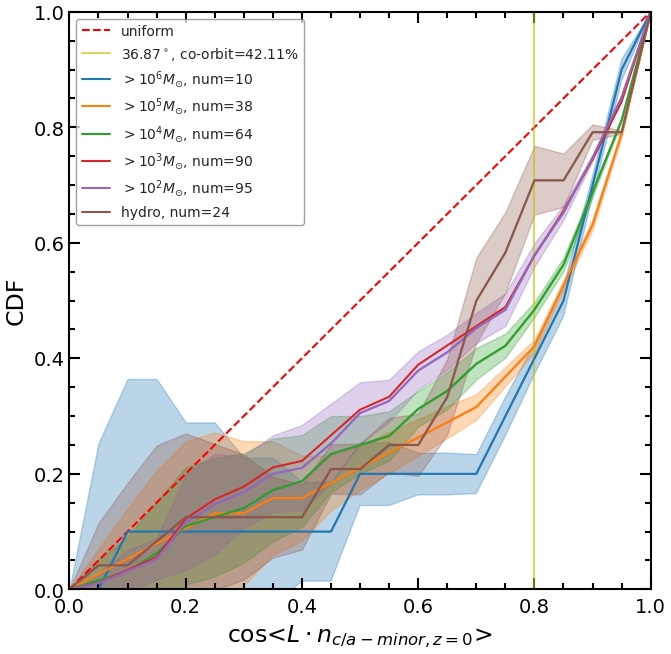

In [56]:
import scipy.stats
import pandas as pd

def bootstrap_error(data):
    sample_size = len(data)
    n_sample = 100
    sample_l = np.zeros((n_sample, sample_size))
    for i in range(n_sample):
        sample = np.random.choice(data, size=sample_size, replace=True)
        sample.sort()
        sample_l[i] = sample
    stds = np.std(sample_l, axis=0)
    n = 19
    step = (sample_size-1) / (n-1)
    index = []
    for i in range(n):
        index.append(int(i* step+ 0.5))
    return stds[index]

hist_bins = np.arange(0,1.05,0.05)
index_l = [r'$>10^6M_{\odot}$',r'$>10^5M_{\odot}$',r'$>10^4M_{\odot}$',r'$>10^3M_{\odot}$',r'$>10^2M_{\odot}$', 'hydro']
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(np.arange(0,1.01,0.01),np.arange(0,1.01,0.01), color = 'red', linestyle = '--', label = 'uniform')
plt.axvline(x = np.cos(np.deg2rad(36.87)), color = 'y', alpha = 0.6,  label = r'36.87$^\circ$, co-orbit=%.2f%%'%(100*sum(angle_l[-2]>(np.cos(36.87/180*np.pi)))/len(angle_l[-2])))
for i in range(len(angle_l)):
    h_1,xedge = np.histogram(angle_l[i],hist_bins)
    index = index_l[i]
    cdf = np.concatenate(([0],np.cumsum(h_1)/np.sum(h_1)))
    std = np.concatenate(([0],bootstrap_error(angle_l[i]),[0]))
    e1, = ax.plot(xedge,cdf, label = f'{index}, num='+str(len(angle_l[i])))
    if i in [0, 1, 2, 4,5]:
        ax.fill_between(xedge, cdf, cdf-std, color = e1.get_color(), alpha = 0.3)
        ax.fill_between(xedge, cdf, cdf+std, color = e1.get_color(), alpha = 0.3)

if (e3_2 == gal_c_a_minor).all():
    axis = 'c_a_minor'
    ax.set_xlabel(r'cos<$L\cdot n_{c/a-minor,z=0}$>')
elif (e3_2 == gal_alpha_axis).all():
    axis = 'alpha-axis'
    ax.set_xlabel(r'cos<$L\cdot n_{\alpha8-axis,z=0}$>')
elif (dm_halo_minor[simulation_num-1]).all():
    axis = 'dmhalo-minor'
    ax.set_xlabel(r'cos<$L\cdot n_{dmhalo-minor,z=0}$>')

# ax.set_xlabel(r'cos<$L\cdot n_{orbitalpole,z=0}$>')
ax.set_ylabel('CDF')
# ax.set_title(simulation_name)
# ax.set_title('M1-M4')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.legend(fontsize = 10)
plt.savefig("fig/"+ simulation_name+ "L_CDF " + axis + "_add_hydro.png", dpi=300)

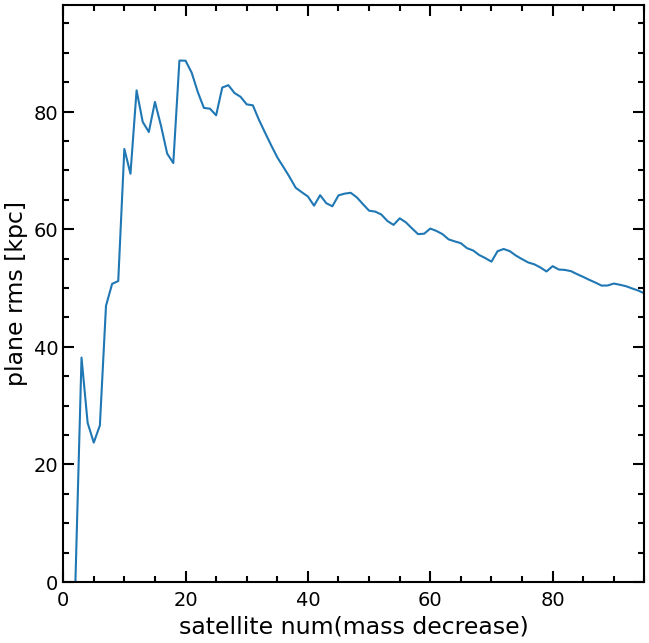

In [57]:
# 定义平面
normal = np.array([0, 0, 0])  # 平面法向量
point = np.array([0, 0, 0])  # 平面上的一点

# 定义点的坐标数据
points = satellite_pos_z0[sort]

# 计算每个点到平面的距离
distances = []
rms_l = np.zeros(len(points))

# i=0, 
for i in range(1, len(points)):
    p = points[i]
    distances.append(abs(np.dot(normal, p - point)))
    c_a, normal  = cal_c_a_ratio(points[:i])
    rms_l[i] = np.mean(distances[:i])
n = np.linspace(1, len(rms_l), len(rms_l))

plt.xlabel('satellite num(mass decrease)')
plt.ylabel('plane rms [kpc]')
# plt.title(simulation_name+ ' plane rms thickness')

plt.ylim(0,2*rms_l[-1])
plt.xlim(0, len(distances)+1)
plt.plot(n, rms_l)
plt.savefig('fig/'+simulation_name+ ' plane rms thickness', dpi=200)

In [58]:
def cal_rms(pos):
    rms_min = 300
    # generate 10000 direction
    npoints = 10000
    Vec_ran = np.zeros((npoints, 3))
    dlong = np.pi*(3-5**0.5)
    dz = 2.0/npoints
    long = 0.
    z = 1-dz/2
    for k in range(npoints):
        r = (1-z*z)**0.5
        Vec_ran[k] = [np.cos(long)*r, np.sin(long)*r, z]
        z = z - dz
        long = long + dlong
    direction = Vec_ran
    # for each direction, calculate rms, find the rms_min

    point = np.array([0, 0, 0])  # 平面上的一点
    satellite_num = len(pos)
    for j in range(len(direction)):
        distances = []
        for i in range(satellite_num):
            distances.append(abs(np.dot(direction[j], pos[i] - point)))
        rms = 0
        for i in range(satellite_num):
            rms += distances[i]**2
        rms = (rms/satellite_num)**0.5
        if rms < rms_min:
            rms_min = rms
    return rms_min

In [59]:
print("All satellite rms=", cal_rms(satellite_pos_z0))
print("Top 11 rms=", cal_rms(satellite_pos_z0[sort][:11]))
print("----------hydro---------")
print("All satellite rms=", cal_rms(hydro_pos))
print("Top 11 rms=", cal_rms(hydro_pos[:11]))

All satellite rms= 67.69107097753098
Top 11 rms= 70.4913956115884
----------hydro---------
All satellite rms= 52.07054173191186
Top 11 rms= 33.87184952241685


# 2.1 draw aitoff

In [192]:
import numpy as np

def rotation_matrix(x, y, z):
    # 计算旋转角度 theta 和 phi
    theta = np.pi - np.arctan2(y, x) # 使用 arctan2 函数得到正确的象限
    rho = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(np.sqrt(x**2 + y**2), z) + np.pi/2

    # 构建旋转矩阵
    Rz = np.array([[np.cos(theta), -np.sin(theta), 0],
                   [np.sin(theta),  np.cos(theta), 0],
                   [0,              0,             1]])

    Ry = np.array([[np.cos(phi),   0, np.sin(phi)],
                   [0,             1,          0],
                   [-np.sin(phi),  0, np.cos(phi)]])

    # 计算总旋转矩阵
    R = np.dot(Ry, Rz)

    return Ry, Rz, R

# 示例：给定点P的坐标 (x, y, z)
x, y, z = e_l[0]

# 计算旋转矩阵
Ry,Rz,R = rotation_matrix(x, y, z)

print(np.dot(Rz, np.array([x, y, z])))

# 用旋转矩阵将点P旋转至x轴上
P_rotated = np.dot(R, np.array([x, y, z]))

print("旋转矩阵：\n", R)
print("旋转后的点P:", P_rotated)
L_rotate = np.dot(R, L.T).T
e_l_rotate = np.dot(R, e_l.T).T
for i in range(5):
    if e_l_rotate[i][0] < 0:
        e_l_rotate[i] = -e_l_rotate[i]

[-2.71637729e-01  7.50267903e-17 -9.62399580e-01]
旋转矩阵：
 [[ 0.27163464 -0.00129548 -0.96239958]
 [-0.00476915 -0.99998863  0.        ]
 [-0.96238863  0.00458982 -0.27163773]]
旋转后的点P: [ 1.00000000e+00  7.50267903e-17 -5.55111512e-17]


In [193]:
R

array([[ 0.27163464, -0.00129548, -0.96239958],
       [-0.00476915, -0.99998863,  0.        ],
       [-0.96238863,  0.00458982, -0.27163773]])

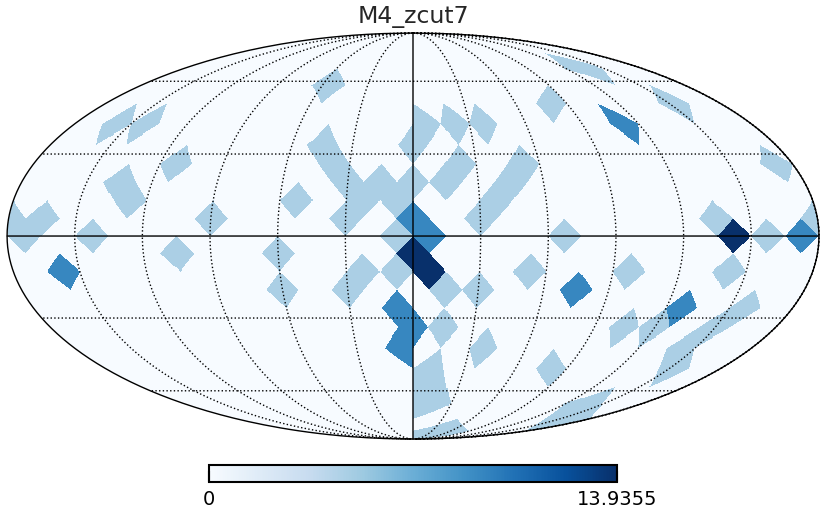

setting the output map dtype to [dtype('float64')]


In [194]:
import healpy as hp
# 将赤道坐标转换为HEALPix坐标
c = SkyCoord(L_rotate, representation_type='cartesian')
c.representation_type = 'unitspherical'
ra_data = np.array(c.ra)
dec_data = np.array(c.dec)

# n = 400
# nside, npix = sky_partition(n)
nside = 6# 分辨率
pix = hp.ang2pix(nside, np.pi/2-np.radians(dec_data), np.radians(ra_data))

# 统计每个像素的数量
hist = np.bincount(pix, minlength=hp.nside2npix(nside))
mean = np.sum(hist)/len(hist)
hist = hist/mean

# hist[hist>6] = 6


# 绘制天球面密度分布图
hp.mollview(hist, 
            # cmap='YlOrRd',
            cmap = 'Blues', 
            # coord=["G"],
            title=simulation_name)

# plt.grid(True)
hp.graticule()
plt.show()
hp.write_map('data/'+simulation_name+".fits", hist, overwrite=True)

In [195]:
theta, phi = hp.pix2ang(nside=6, ipix=[0, 1, 2, 3, 4])

In [196]:
hist[hist>12]

array([13.93548387, 13.93548387, 13.93548387])

In [197]:
c = SkyCoord(e_l_rotate, unit='kpc', representation_type='cartesian')
c.representation_type = 'unitspherical'
e_l_ra_rad = c.ra.wrap_at(180 * unit.deg).radian
e_l_dec_rad = c.dec.radian

In [198]:
# # save to csv
# data = {'simulation_num':simulation_num,
#         'e_l_ra_rad':e_l_ra_rad,
#         'e_l_dec_rad':e_l_dec_rad}
# axis_df = pd.DataFrame(data)
# if simulation_num == 1:
#         axis_df.to_csv('axis_stack.csv',index=False)
# else:
#         df_saved = pd.read_csv('axis_stack.csv')
#         df_ = df_saved.append(axis_df)
#         df_.to_csv('axis_stack.csv',index=False)

3.7960911230876664 1.5707963267948966
2.48709418409192 0.0


<Figure size 9000x7500 with 0 Axes>

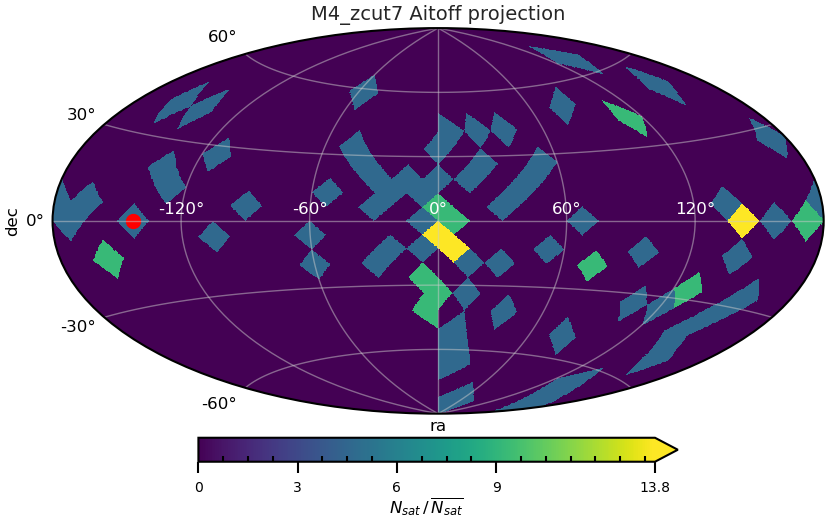

In [199]:
legends = ['halo minor axis', 'galform c/a minor axis', r'galform $\alpha8$8 axis', 'hydro c/a minor axis', r'hydro $\alpha8$8 axis']

from healpy.newvisufunc import projview, newprojplot
m = hp.read_map(
    "data/%s.fits"%(simulation_name)
)
# aitoff view plot with graticule and axis labels and vertical color bar, when min and max is set
# to be different than the min, max of the data, the colorbar is extended

fig = plt.figure(figsize=(30,25), dpi = 300)
max_ = round(np.max(hist))
projview(
    m,
    fig,
    graticule=True,
    graticule_labels=True,
    # graticule_color='white',
    unit="$N_{sat}\, / \, \overline{N_{sat}}$",
    xlabel="ra",
    ylabel="dec",
    # cb_orientation="vertical",  
    phi_convention="symmetrical",
    xtick_label_color="white",
    # cmap='YlOrRd',
    
    # cmap =  'gist _stern',
    # cbar_ticks=np.linspace(0,max_,6),
    cbar_ticks=[0,3,6,9,13.8],
    # max=max_,
    # longitude_grid_spacing=30,
    projection_type="aitoff",
    title=simulation_name + " Aitoff projection",
)
# hp.graticule()
# for i in range(len(theta)):
#     # newprojplot(theta = np.pi/2 - e_l_ra_rad[i], phi=e_l_dec_rad[i], marker='*', markersize=8, label=legends[i])
#     plt.scatter(theta[i], phi[i], marker='*', linewidth=2,)
max_index = np.argmax(m)
nside=6
# 将像素索引转换为天球坐标
theta, phi = hp.pix2ang(nside=6, ipix=max_index)
dec = np.pi/2 - theta
if phi > np.pi:
    ra = np.pi*2 - phi
else:
    ra = phi
print(phi, theta)
print(ra, dec)

# 在图中的最大像素
# \处添加一个五角星
plt.scatter(-ra, dec, color = 'red')
# plt.scatter(theta, phi)
# plt.scatter(np.pi/2 - lon, lat, marker='*', s=10, color='red')
# plt.scatter(0, np.pi/2,color='red')

<Figure size 9000x7500 with 0 Axes>

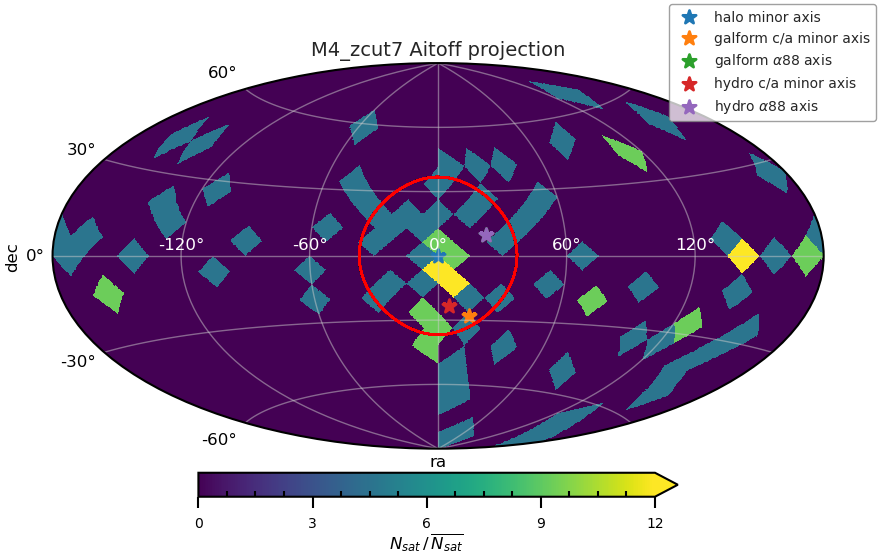

In [200]:
legends = ['halo minor axis', 'galform c/a minor axis', r'galform $\alpha8$8 axis', 'hydro c/a minor axis', r'hydro $\alpha8$8 axis']

from healpy.newvisufunc import projview, newprojplot
m = hp.read_map(
    "data/%s.fits"%(simulation_name)
)
# aitoff view plot with graticule and axis labels and vertical color bar, when min and max is set
# to be different than the min, max of the data, the colorbar is extended

fig = plt.figure(figsize=(30,25), dpi = 300)
max_ = round(np.max(hist))
projview(
    m,
    fig,
    graticule=True,
    graticule_labels=True,
    # graticule_color='white',
    unit="$N_{sat}\, / \, \overline{N_{sat}}$",
    xlabel="ra",
    ylabel="dec",
    # cb_orientation="vertical",  
    phi_convention="symmetrical",
    xtick_label_color="white",
    # cmap='YlOrRd',
    
    # cmap =  'gist _stern',
    # cbar_ticks=np.linspace(0,max_,6),
    cbar_ticks=[0,3,6,9,12],
    # max=max_,
    # longitude_grid_spacing=30,
    projection_type="aitoff",
    title=simulation_name + " Aitoff projection",
)
# hp.graticule()
for i in range(len(e_l_ra_rad)):
    # newprojplot(theta = np.pi/2 - e_l_ra_rad[i], phi=e_l_dec_rad[i], marker='*', markersize=8, label=legends[i])
    plt.scatter(e_l_ra_rad[i], e_l_dec_rad[i], marker='*', linewidth=2, label=legends[i])

# def lonlat(theta, phi):
#     """Converts theta and phi to longitude and latitude"""

#     longitude = np.asarray(phi)
#     latitude = np.pi / 2 - np.asarray(theta)
#     return longitude, latitude
# cbar = fig.colorbar(ax, ticks=np.linspace(0,max_,3))
# cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar


phi = np.linspace(0, 2.*np.pi, 72)  #36 points
r = np.radians(36.87)
x = r*np.cos(phi) + np.pi/2
y = r*np.sin(phi)
for i in range(len(x)):
    newprojplot(x, y,color='r')#, fill=True)

# ax = plt.gca()
# flip = getattr(ax, "healpy_flip", "astro")
# for i in range(len(e_l_ra_data)):
#     longitude, latitude = lonlat(e_l_ra_data[i], e_l_dec_data[i])
#     if flip == "astro":
#         longitude = longitude * -1
#     plt.plot(longitude, latitude, marker='x', markersize=8, label = legends[i])
#         # plt.legend()
#     # print(ax,"abc")

    # newprojplot(theta=e_l_ra_data[i], phi=e_l_dec_data[i], marker='x', markersize=15, label = legends[i])
# plt.legend()
# ax = plt.gca()

# plt.legend(loc='lower left', prop={'size': 9})
plt.legend(loc=(0.8,0.85), prop={'size': 10})
# plt.legend(loc=(0.5,0), prop={'size': 10})
# plt.savefig('fig/'+simulation_name + 'aitoff.png', dpi=500)
plt.show()

# 2.2 MW

In [201]:
# MW_data = np.loadtxt("/home/zhaox/app/data/MW_data.txt")
MW_data = np.loadtxt("/home/zhaox/app/data/MW_data3.txt") # combine EDR3 & DR2
pos_MW = MW_data[:,:3]
vel_MW = MW_data[:,3:]
L_MW = np.cross(pos_MW, vel_MW)
c_a, MW_c_a_minor = cal_c_a_ratio(pos_MW)
alpha, MW_alpha_axis = cal_alpha(L_MW)
print("c/a=", c_a, "\n", chr(945)+"8=", alpha)
print("angle between = ", cal_angle(MW_c_a_minor, MW_alpha_axis))
print("Top 11 rms=", cal_rms(pos_MW))

c/a= 0.18198247094063846 
 α8= 28.35328660568089
angle between =  30.294577886844262
Top 11 rms= 20.115822937162108


# 3 trace infall history

In [202]:
def draw_cdf(data,legends, title, xlabel, save=False):
    hist_bins = np.arange(0,1.05,0.05)
    index_l = legends

    fig = plt.figure()
    ax = fig.add_subplot()
    # ax.step((xedge[1:]+xedge[:-1])/2.,(h_phe)/np.sum(h_phe),'r-',where='mid')
    # ax.set_xlabel(r'$\Delta RV_{max}$ (km s$^{-1}$)',fontsize=12)
    ax.plot(np.arange(0,1.01,0.01),np.arange(0,1.01,0.01), color = 'red', linestyle = '--', label = 'uniform')

    for i in range(len(data)):
        # index = index_l[i]
        h_1,xedge = np.histogram(data[i],hist_bins)
        index = index_l[i]
        # print(y_fit)
        cdf = np.concatenate(([0],np.cumsum(h_1)/np.sum(h_1)))
        e1, = ax.plot(xedge,cdf, label = f'{index}')
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel('CDF')
    # ax.set_title(title)
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    plt.legend(fontsize = 10)
    if save == True:
        plt.savefig('fig/' + simulation_name + title +'.png', dpi=300)

In [203]:
file

'/home/zhaox/Magpie/Destruction/satellite_orbits_Galform/M4_MR.hdf5'

In [204]:
# central_R200 = np.loadtxt('data/central_r200_'+ simulation_name)

In [205]:
central_R200 = read_central_r200(simulation_name)[::-1]

199
198
197
196
195
194
193
192
191
190
189
188
187
186
185
184
183
182
181
180
179
178
177
176
175
174
173
172
171
170
169
168
167
166
165
164
163
162
161
160
159
158
157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10


In [206]:
is_within_r200 = np.linalg.norm(satellite_pos_z0, axis=1)<central_R200_z0*1000/h
satellite_mstar_r200 = satellite_mstar[is_within_r200]
satellite_pos_r200 = satellite_pos[is_within_r200]
satellite_vel_r200 = satellite_vel[is_within_r200]
lookbackTime = cosmo.age(0) - t

In [207]:
satellite_pos_r200.shape

(79, 199, 3)

In [208]:
dis_l.shape

(74, 199)

In [209]:
central_R200

array([  0.62926255,   1.10066952,   1.21863466,   1.05131726,
         2.11043288,   2.13232907,   1.60724078,   1.66102611,
         2.05680005,   3.27753345,   3.05575035,   4.68200939,
         3.5488304 ,   4.22944276,   6.43042214,   8.88871919,
         9.30033342,  10.43614324,  16.45668962,  17.304335  ,
        17.9371883 ,  18.7445145 ,  21.15815506,  21.57856899,
        13.94432294,  14.58709023,  15.20219455,  15.87041047,
        16.58666305,  17.21745012,  17.80047235,   3.9530386 ,
         4.36254328,  19.04737206,   6.06303921,  21.03793062,
         6.61217273,   6.53015383,   5.49488229,  23.47678404,
        23.96193929,  24.55180585,  25.39314866,  23.21333247,
        25.0749824 ,  27.33025611,  30.14781469,  33.99689497,
        36.6233307 ,  38.28619927,  17.7513828 ,  18.77747991,
        36.64129383,  21.68416043,  37.98310298,  38.67725674,
        39.46412393,  40.21780005,  41.17526362,  42.03061897,
        43.03182824,  44.58921148,  47.16668435,  49.52

In [210]:
satellite_num_r200 = len(satellite_pos_r200)
dis_l = np.zeros((satellite_num_r200,199))
infall_index = np.zeros(satellite_num_r200 , dtype=int)
for i in range(satellite_num_r200):
    for j in range(199):
        dis_l[i][j] = np.linalg.norm(satellite_pos_r200[i][j])
        if (dis_l[i][j]> central_R200[j] and infall_index[i]==0):
            infall_index[i] = j

IndexError: index 189 is out of bounds for axis 0 with size 189

In [ ]:
infall_index

array([ 11,  15,  15,  19,  20,   2,   5,  22,  34,  21,  34,  14,  23,
        18,  18,  22,  17,  22,  19,  17,  49,  36,  83,  29,  18,  22,
        40,  19,  15,  53,  19,  37,  69,  18,  69,  20,  55,  18,  19,
        79,  43,  74,  13,  69,  86, 116,  10,  80,  99,  20,  12,  82,
        74,  18,  74,  69,  49,  83,  19,  18,  16, 138,  18,  20,  74,
        74,  19,  30,  16,  19,  18,  19,  20,  74])

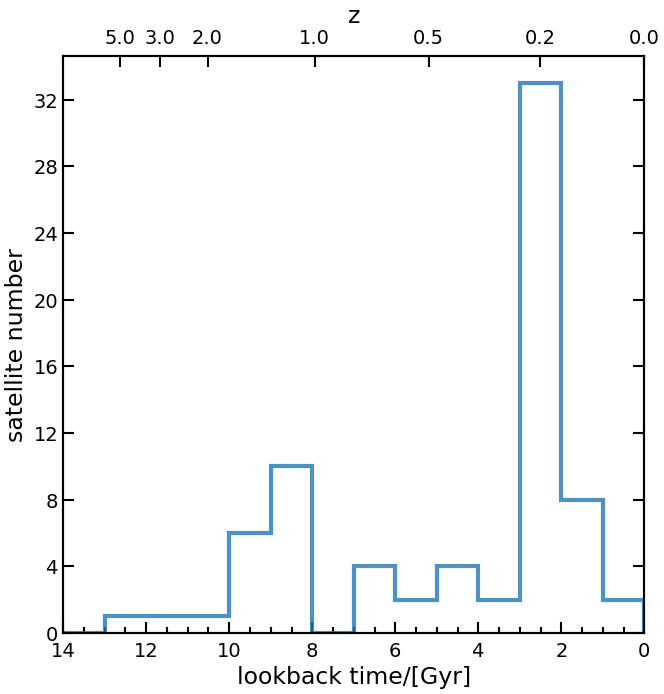

In [ ]:
z = 1/a - 1
z_infall = z[infall_index]
infall_lbtime = np.array([cosmo.lookbackTime(z_) for z_ in z_infall])

from matplotlib.ticker import MaxNLocator
# plt.title(simulation_name + ' infall time PDF')
ax1 = plt.subplot()
bins = np.linspace(0,14,15)
N, bins, patches = ax1.hist(infall_lbtime, bins,alpha=0.8, histtype='step', linewidth=3)
ax1.set_xlabel('lookback time/[Gyr]')
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
# ax1.arrow(lbtime[0],2, 0, -1, width = 0.1, color = 'red')
# ax1.text(lbtime[0]+1,2.5, "lmc infall", fontsize=13)
# ax1.arrow(lbtime[1],2, 0, -1, width = 0.1, color = 'red')
# ax1.text(lbtime[1]+1,2.5, "smc infall", fontsize=13)
# ax1.invert_xaxis()
sort = np.argsort(satellite_mstar[is_within_r200,0])

# ax1.arrow(infall_lbtime[sort[-1]],2, 0, -1, width = 0.1, color = 'orange')
# ax1.text(infall_lbtime[sort[-1]]+1,2.5, "lmc infall", fontsize=13)
# ax1.arrow(infall_lbtime[sort[-2]],2, 0, -1, width = 0.1, color = 'orange')
# ax1.text(infall_lbtime[sort[-2]]+1,2.5, "smc infall", fontsize=13)

ax1.set_xlim(14,0)

# for i in range(1,5):
#     patches[-i].set_facecolor('c')

def lbtime2z(lbtime):
    t_universe = cosmo.age(0)
    z = cosmo.age(t_universe - lbtime, inverse = True)
    return ["%.1f" % z_ for z_ in z]

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
new_tick_locations = np.array([0.01, cosmo.lookbackTime(0.2), cosmo.lookbackTime(0.5), cosmo.lookbackTime(1), cosmo.lookbackTime(2), cosmo.lookbackTime(3), cosmo.lookbackTime(5)])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(lbtime2z(new_tick_locations))
# ax2.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
# ax2.xtick.minor.visible:=False
# ax.xaxis.set_minor_locator([])
ax2.minorticks_off()
ax2.set_xlabel('z')
ax1.set_ylabel('satellite number')
plt.savefig('fig/'+simulation_name + ' infall time PDF.png', dpi=300)

In [ ]:
early_infall_galaxy = np.where(infall_lbtime>8)[0]
late_infall_galaxy = np.where(infall_lbtime<6)[0]
born_infall_galaxy = np.where(z_infall>3.0)[0]
set_born_infall_galaxy = set(born_infall_galaxy)
early_infall_galaxy_remove_born_infall = np.array([x for x in early_infall_galaxy if x not in set_born_infall_galaxy])
print(early_infall_galaxy_remove_born_infall, '\n', late_infall_galaxy)

[22 32 34 39 41 43 44 45 47 48 51 52 54 55 57 64 65 73] 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 23 24 25
 26 27 28 30 31 33 35 37 38 40 42 46 49 50 53 58 59 60 62 63 66 67 68 69
 70 71 72]


In [ ]:
satellite_L_infall = np.zeros((satellite_num_r200,3))
satellite_L_r200 = np.cross(satellite_vel_r200, satellite_pos_r200)
for i in range(len(satellite_L_r200)):
    # satellite_L_r200[i] = satellite_L_r200[i]/ np.linalg.norm(satellite_L_r200[i])
    satellite_L_infall[i] = satellite_L_r200[i][infall_index[i]]

In [ ]:
satellite_L_r200.shape

(74, 199, 3)

In [ ]:
satellite_vel_r200.shape

(74, 199, 3)

In [ ]:
# e3_2 = dm_halo_minor[simulation_num-1]
e3_2 = gal_c_a_minor
# e3_2 = gal_alpha_axis
satellite_L_r200_infall_late = satellite_L_infall[late_infall_galaxy]
satellite_L_r200_infall_late = satellite_L_r200_infall_late/np.linalg.norm(satellite_L_r200_infall_late, axis=1, keepdims=True)
angle_r200_infall_late = abs(np.dot(satellite_L_r200_infall_late, e3_2))

satellite_L_r200_infall_early = satellite_L_infall[early_infall_galaxy]
satellite_L_r200_infall_early = satellite_L_r200_infall_early/np.linalg.norm(satellite_L_r200_infall_early, axis=1, keepdims=True)
angle_r200_infall_early = abs(np.dot(satellite_L_r200_infall_early, e3_2))

satellite_L_r200_early_remove_born = satellite_L_infall[early_infall_galaxy_remove_born_infall]
satellite_L_r200_early_remove_born = satellite_L_r200_early_remove_born/ np.linalg.norm(satellite_L_r200_early_remove_born, axis=1, keepdims=True)
angle_r200_early_remove_born = abs(np.dot(satellite_L_r200_early_remove_born, e3_2))

satellite_L_infall = satellite_L_infall/ np.linalg.norm(satellite_L_infall, axis=1, keepdims=True)
angle_satellite_L_infall = abs(np.dot(satellite_L_infall, e3_2))

In [ ]:
angle_r200_infall_early.shape

(19,)

In [ ]:
angle_r200_early_remove_born.shape

(18,)

In [ ]:
is_within_r200.shape

(98,)

In [ ]:
len(angle_l[-2])

98

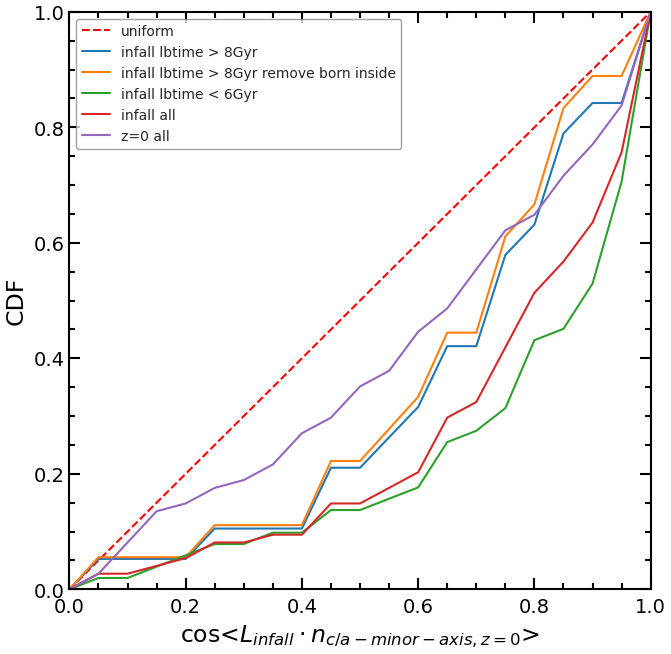

In [ ]:
# xlabel = 'cos<$L_{infall}\cdot n_{dm halo minor,z=0}$>'
# xlabel = r'cos<$L_{infall}\cdot n_{\alpha8-axis,z=0}$>'
xlabel = r'cos<$L_{infall}\cdot n_{c/a-minor-axis,z=0}$>'
draw_cdf(data = [angle_r200_infall_early, 
                 angle_r200_early_remove_born,angle_r200_infall_late, 
                 angle_satellite_L_infall, 
                 np.array(angle_l[-2])[is_within_r200]], 
         legends =["infall lbtime > 8Gyr", 
                   "infall lbtime > 8Gyr remove born inside", 
                   "infall lbtime < 6Gyr", 
                   "infall all",
                   "z=0 all"],
         xlabel = xlabel,
         title = 'depedence on infall time', 
         save = True)

In [ ]:
satellite_R200.shape

(98,)

In [ ]:
sort = np.argsort(satellite_mstar[is_within_r200][:,0])
bring_by_lmc = np.full(sum(is_within_r200),False)
lmc_index = sort[-1]
lmc_infall_index = infall_index[lmc_index]
# lmc_r200 = 227.2 * (satellite_mhalo[is_within_r200][lmc_index, lmc_infall_index]/1.252e12)**0.3333
lmc_r200 = satellite_R200[is_within_r200][lmc_index]
print("lmc_r200=", lmc_r200)
for i in range(len(satellite_pos_r200)):
    distance_to_lmc = np.linalg.norm(satellite_pos_r200[i][lmc_infall_index] - satellite_pos_r200[lmc_index][lmc_infall_index])
    # print(distance_to_lmc)
    if  distance_to_lmc < lmc_r200:
        bring_by_lmc[i] = True
print("num bring by lmc=", sum(bring_by_lmc))

lmc_r200= 157.36134338378906
num bring by lmc= 35


In [ ]:
sort = np.argsort(satellite_mstar[is_within_r200][:,0])
bring_by_smc = np.full(sum(is_within_r200),False)
smc_index = sort[-2]
smc_infall_index = infall_index[smc_index]
# smc_r200 = 227.2 * (satellite_mhalo[is_within_r200][smc_index, smc_infall_index]/1.252e12)**0.3333
smc_r200 = satellite_R200[is_within_r200][smc_index]
print("smc_r200=", smc_r200)
for i in range(len(satellite_pos_r200)):
    distance_to_smc = np.linalg.norm(satellite_pos_r200[i][smc_infall_index] - satellite_pos_r200[smc_index][smc_infall_index])
    # print(distance_to_smc)
    if  distance_to_smc < smc_r200:
        bring_by_smc[i] = True
print("num bring by smc=",sum(bring_by_smc))

smc_r200= 126.66051483154297
num bring by smc= 32


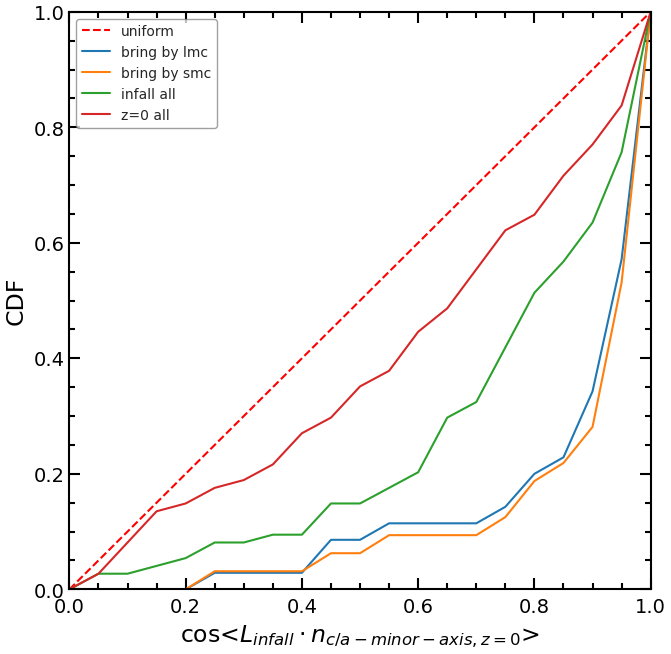

In [ ]:
L_bring_by_lmc_infall = satellite_L_infall[bring_by_lmc]
angle_bring_by_lmc_infall = abs(np.dot(L_bring_by_lmc_infall, e3_2))
L_bring_by_smc_infall = satellite_L_infall[bring_by_smc]
angle_bring_by_smc_infall = abs(np.dot(L_bring_by_smc_infall, e3_2))


draw_cdf([angle_bring_by_lmc_infall, 
          angle_bring_by_smc_infall, 
          angle_satellite_L_infall, 
          np.array(angle_l[-2])[is_within_r200]], 
        ["bring by lmc", "bring by smc", "infall all","z=0 all"],
        title = 'LMC & SMC influence',
        # xlabel = r'cos<$L_{infall}\cdot n_{\alpha8-axis,z=0}$>',
        xlabel = r'cos<$L_{infall}\cdot n_{c/a-minor-axis,z=0}$>',
        save=True)

In [ ]:
import pandas as pd

data = {'simulation_num': np.full(len(infall_lbtime), simulation_num),
        'infall_lbtime':infall_lbtime,
        'angle_satellite_L_infall':angle_satellite_L_infall,
        'z=0 all':np.array(angle_l[-2])[is_within_r200],
        'bring_by_lmc':bring_by_lmc,
        'bring_by_smc':bring_by_smc}

df = pd.DataFrame(data)

In [ ]:
df

,simulation_num,infall_lbtime,angle_satellite_L_infall,z=0 all,bring_by_lmc,bring_by_smc
0,2,1.366229,0.151500,0.117154,False,False
1,2,1.875217,0.685251,0.463488,False,False
2,2,1.875217,0.613885,0.114794,False,False
3,2,2.388623,0.995750,0.962220,True,True
4,2,2.517505,0.915221,0.632747,True,True
...,...,...,...,...,...,...
69,2,2.388623,0.969954,0.944699,True,True
70,2,2.259931,0.991261,0.921015,True,True
71,2,2.388623,0.999217,0.845635,True,True
72,2,2.517505,0.829000,0.242394,True,True


In [170]:
df_saved = pd.read_csv('satellite_infall_data_new.csv')
df_ = df_saved.append(df)
df_.to_csv('satellite_infall_data_new.csv',index=False)

/tmp/ipykernel_141721/3391613606.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ = df_saved.append(df)
